In [1]:
# import kagglehub
# path = kagglehub.dataset_download("soumikrakshit/nyu-depth-v2")
# print("Path to dataset files:", path)

In [2]:
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F  
from torchvision.models import resnet18
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import numpy as np
import networkx as nx
import torch.optim as optim

import pandas as pd
import torch_geometric
 
import os

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from torch.utils.data import Dataset, DataLoader

In [3]:
NYU_PATH = "/home/sid/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data"
nyu_train_csv = os.path.join(NYU_PATH, "nyu2_train.csv")
nyu_test_csv = os.path.join(NYU_PATH, "nyu2_test.csv")

if os.path.exists(nyu_train_csv):
    nyu_train_df = pd.read_csv(nyu_train_csv)
    print("NYU Train CSV:", nyu_train_df.shape)
    display(nyu_train_df.head())
else:
    print("NYU Train CSV not found!")

NYU Train CSV: (50687, 2)


,data/nyu2_train/living_room_0038_out/37.jpg,data/nyu2_train/living_room_0038_out/37.png
0,data/nyu2_train/living_room_0038_out/115.jpg,data/nyu2_train/living_room_0038_out/115.png
1,data/nyu2_train/living_room_0038_out/6.jpg,data/nyu2_train/living_room_0038_out/6.png
2,data/nyu2_train/living_room_0038_out/49.jpg,data/nyu2_train/living_room_0038_out/49.png
3,data/nyu2_train/living_room_0038_out/152.jpg,data/nyu2_train/living_room_0038_out/152.png
4,data/nyu2_train/living_room_0038_out/142.jpg,data/nyu2_train/living_room_0038_out/142.png


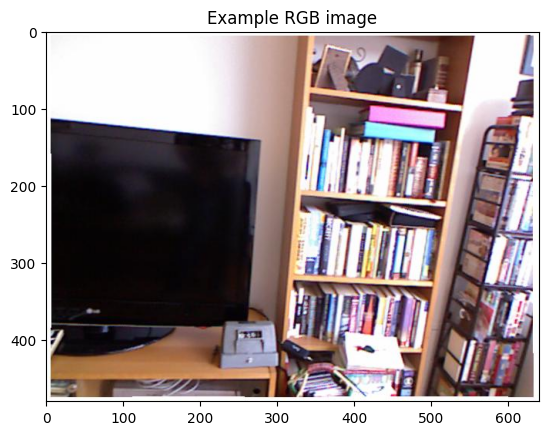

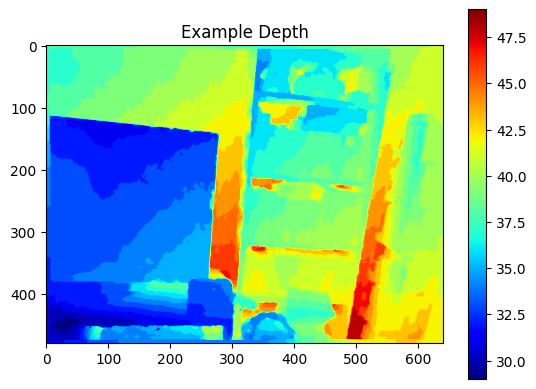

In [4]:
sample_image_path = "/home/sid/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train/living_room_0020_out/208.jpg"
sample_depth_path = "/home/sid/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train/living_room_0020_out/208.png"

if os.path.exists(sample_image_path):
    img = cv2.imread(sample_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #  BGR -> RGB for plt
    plt.imshow(img)
    plt.title("Example RGB image")
    plt.show()
else:
    print("Sample RGB image not found at:", sample_image_path)

if os.path.exists(sample_depth_path):
    depth = cv2.imread(sample_depth_path, cv2.IMREAD_UNCHANGED)
    plt.imshow(depth, cmap='jet')
    plt.title("Example Depth")
    plt.colorbar()
    plt.show()
else:
    print("Sample Depth image not found at:", sample_depth_path)

In [5]:
from torch.utils.data import DataLoader, Dataset
CSV_PATH_TRAIN = "/home/sid/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train.csv"
CSV_PATH_TEST = "/home/sid/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_test.csv"
ROOT_DIR = "/home/sid/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/"


nyu_train_df = pd.read_csv(CSV_PATH_TRAIN,   
                           sep=',',
                           header=None, 
                           names=["rgb", "depth"])

nyu_test_df = pd.read_csv(CSV_PATH_TEST, 
                          sep=',', 
                          header=None,
                          names=["rgb", "depth"])

In [8]:
class DepthDataset(Dataset):
    def __init__(self, dataframe, root_dir, img_height=240, img_width=320, transform=None):
        """
        :param dataframe: pd.DataFrame [rgb, depth]
        :param root_dir: folder dataframe
        :param img_height, img_width: resize to
        :param transform: augmentation
        """
        self.df = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        rgb_path = os.path.join(self.root_dir, row["rgb"])   
        #print(rgb_path, os.path.exists(rgb_path))
        depth_path = os.path.join(self.root_dir, row["depth"])
        #print(depth_path, os.path.exists(depth_path))
        

        # (BGR -> RGB)
        rgb_img = cv2.imread(rgb_path)
        if rgb_img is None:
            print("Warning: Failed to load image:", rgb_path)
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
        rgb_img = cv2.resize(rgb_img, (self.img_width, self.img_height))

        # Depth 
        depth_img = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        depth_img = cv2.resize(depth_img, (self.img_width, self.img_height))

        # to float32
        rgb_img = rgb_img.astype(np.float32) / 255.0
        depth_img = depth_img.astype(np.float32)

        # to tensor PyTorch: (C,H,W)
        rgb_tensor = torch.from_numpy(np.transpose(rgb_img, (2,0,1)))   # (3, H, W)
        depth_tensor = torch.from_numpy(depth_img).unsqueeze(0)         # (1, H, W)

        # 
        # if self.transform:
        #     ...

        return rgb_tensor, depth_tensor

In [9]:
IMG_HEIGHT = 480
IMG_WIDTH = 640
BATCH_SIZE = 4

train_dataset = DepthDataset(nyu_train_df, ROOT_DIR, IMG_HEIGHT, IMG_WIDTH)
test_dataset = DepthDataset(nyu_test_df, ROOT_DIR, IMG_HEIGHT, IMG_WIDTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Train samples: 50688
Test samples: 654


In [15]:
# ---------------------------------------------------------------------
# Helper: Build grid graph edge index from a feature map of size H x W.
# ---------------------------------------------------------------------
def build_grid_edge_index(H, W, connectivity=4):
    nodes = H * W
    indices = np.arange(nodes).reshape(H, W)
    edge_list = []
    if connectivity == 4:
        offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    elif connectivity == 8:
        offsets = [(-1, 0), (1, 0), (0, -1), (0, 1),
                   (-1, -1), (-1, 1), (1, -1), (1, 1)]
    else:
        raise ValueError("connectivity must be 4 or 8")
    for i in range(H):
        for j in range(W):
            current = indices[i, j]
            for di, dj in offsets:
                ni, nj = i + di, j + dj
                if 0 <= ni < H and 0 <= nj < W:
                    neighbor = indices[ni, nj]
                    edge_list.append([current, neighbor])
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    return edge_index

# ---------------------------------------------------------------------
# CNN2GNN_FlyPrior Model: integrates a fly-brain prior with CNN-GNN architecture.
# ---------------------------------------------------------------------
class CNN2GNN_FlyPrior(nn.Module):
    def __init__(self, cnn_out_channels=64, gnn_hidden_dim=64, num_gnn_layers=2, fly_embed_dim=64):
        super(CNN2GNN_FlyPrior, self).__init__()
        # 1. CNN Backbone: Use a pretrained ResNet-18.
        backbone = resnet18(pretrained=True)
        self.cnn_backbone = nn.Sequential(*list(backbone.children())[:-2])
        # Reduce channels from 512 to cnn_out_channels.
        self.cnn_reducer = nn.Conv2d(512, cnn_out_channels, kernel_size=1)
        
        # 2. GNN Layers: Stack of GCNConv layers.
        self.gnn_layers = nn.ModuleList()
        in_channels = cnn_out_channels
        for _ in range(num_gnn_layers):
            self.gnn_layers.append(GCNConv(in_channels, gnn_hidden_dim))
            in_channels = gnn_hidden_dim
        
        # 3. FlyBrain Prior: A learnable embedding per node.
        # Assume fixed grid size after CNN (e.g., if feature map is 20x30, then num_nodes=600).
        self.num_nodes = 600  # Adjust this value to match your CNN feature map size.
        self.fly_prior = nn.Embedding(self.num_nodes, fly_embed_dim)
        
        # 4. Fusion: Fuse GNN output with the fly prior.
        self.fusion = nn.Linear(gnn_hidden_dim + fly_embed_dim, gnn_hidden_dim)
        
        # 5. Decoder: Upsample fused grid features back to a dense depth map.
        self.decoder = nn.Sequential(
            nn.Conv2d(gnn_hidden_dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)  # Output single-channel depth map.
        )
    
    def forward(self, x):
        """
        x: Input RGB image tensor of shape [B, 3, H_img, W_img]
        Returns:
            Depth map tensor of shape [B, 1, H_img, W_img]
        """
        B, C, H_img, W_img = x.shape
        # 1. Extract CNN features.
        feat_map = self.cnn_backbone(x)   # [B, 512, H_feat, W_feat]
        feat_map = self.cnn_reducer(feat_map)  # [B, cnn_out_channels, H_feat, W_feat]
        B, C_feat, H_feat, W_feat = feat_map.shape  # Use C_feat for channel dimension.
        num_nodes = H_feat * W_feat  # Expected to match self.num_nodes (or adjust accordingly).
        
        # Build grid graph edge_index (same for all images).
        edge_index = build_grid_edge_index(H_feat, W_feat, connectivity=4).to(x.device)
        
        outputs = []
        for b in range(B):
            # Reshape CNN feature map into node features: [num_nodes, C_feat]
            node_feats = feat_map[b].view(C_feat, -1).t()  # [num_nodes, C_feat]
            
            # 2. Pass node features through GNN layers.
            for conv in self.gnn_layers:
                node_feats = conv(node_feats, edge_index)
                node_feats = F.relu(node_feats)
            
            # 3. Get fly brain prior embedding.
            if num_nodes != self.num_nodes:
                fly_embed = self.fly_prior.weight[:num_nodes]
            else:
                fly_embed = self.fly_prior.weight  # [num_nodes, fly_embed_dim]
            
            # 4. Fusion: Concatenate and apply linear fusion.
            fused = torch.cat([node_feats, fly_embed], dim=1)  # [num_nodes, gnn_hidden_dim + fly_embed_dim]
            fused = self.fusion(fused)  # [num_nodes, gnn_hidden_dim]
            
            # 5. Reshape fused node features back to grid: [1, gnn_hidden_dim, H_feat, W_feat]
            fused_grid = fused.t().view(1, -1, H_feat, W_feat)
            
            # 6. Decode fused features into a depth map.
            depth_map = self.decoder(fused_grid)  # [1, 1, H_out, W_out]
            # Upsample the predicted depth map to match the original input resolution.
            depth_map = F.interpolate(depth_map, size=(H_img, W_img), mode='bilinear', align_corners=True)
            outputs.append(depth_map)
        
        outputs = torch.cat(outputs, dim=0)  
        return outputs

In [16]:
IMG_HEIGHT = 480
IMG_WIDTH = 640
BATCH_SIZE = 4

train_dataset = DepthDataset(nyu_train_df, ROOT_DIR, img_height=IMG_HEIGHT, img_width=IMG_WIDTH)
test_dataset = DepthDataset(nyu_test_df, ROOT_DIR, img_height=IMG_HEIGHT, img_width=IMG_WIDTH)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Train samples: 50688
Test samples: 654


In [19]:
# Instantiate your model architecture first, then load the weights.
model = CNN2GNN_FlyPrior(cnn_out_channels=64, gnn_hidden_dim=64, num_gnn_layers=2, fly_embed_dim=64)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("cnn2gnn_flyprior.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']

model.to(device)
model.eval()  # Set to evaluation mode if you are testing
print("Model loaded and ready for inference!")

Model loaded and ready for inference!


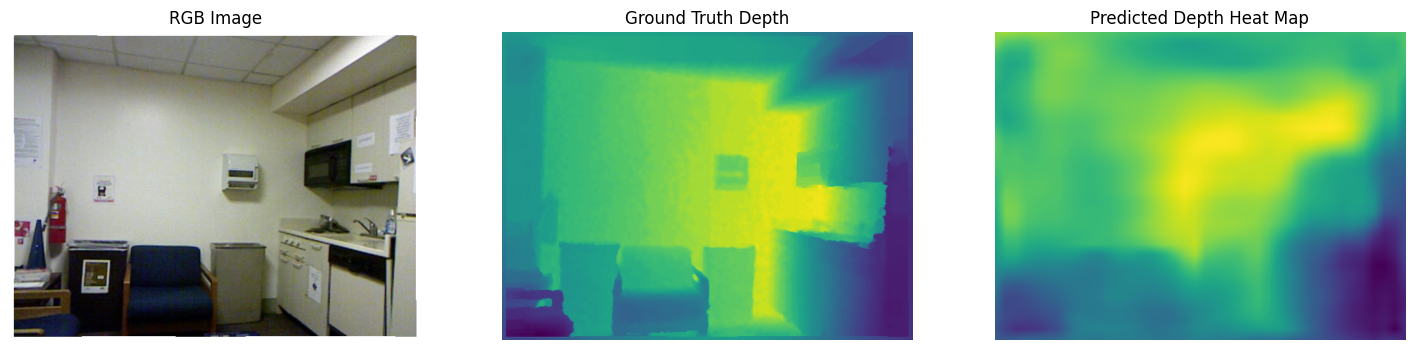

In [20]:
import matplotlib.pyplot as plt

def test_and_visualize(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Get one batch from the test loader (or iterate over several)
        for rgb_tensor, depth_tensor in data_loader:
            rgb_tensor = rgb_tensor.to(device)
            depth_tensor = depth_tensor.to(device).float()
            
            # Run the model to get the predicted depth map.
            pred_depth = model(rgb_tensor)  # Shape: [B, 1, H, W]
            
            # Move to CPU for visualization.
            pred_depth = pred_depth.cpu().numpy()
            depth_tensor = depth_tensor.cpu().numpy()
            rgb_tensor = rgb_tensor.cpu().numpy()
            
            # Visualize the first image in the batch.
            idx = 0
            rgb_img = np.transpose(rgb_tensor[idx], (1, 2, 0))  # Convert to H x W x C.
            gt_depth = depth_tensor[idx, 0, :, :]
            pred_heatmap = pred_depth[idx, 0, :, :]

            plt.figure(figsize=(18, 6))

            # Original RGB image.
            plt.subplot(1, 3, 1)
            plt.imshow(rgb_img)
            plt.title("RGB Image")
            plt.axis("off")

            # Ground truth depth.
            plt.subplot(1, 3, 2)
            plt.imshow(gt_depth, cmap='viridis')
            plt.title("Ground Truth Depth")
            plt.axis("off")

            # Predicted depth heat map.
            plt.subplot(1, 3, 3)
            plt.imshow(pred_heatmap, cmap='viridis')
            plt.title("Predicted Depth Heat Map")
            plt.axis("off")

            plt.show()
            
            # Visualize one batch only.
            break

# Example usage:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_and_visualize(model, test_loader, device)

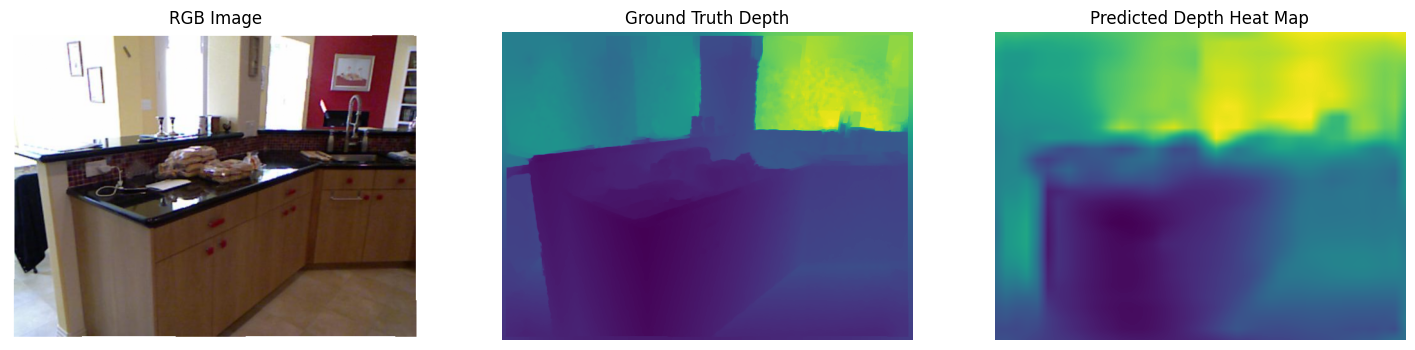

In [21]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

test_and_visualize(model, test_loader, device)